# Project 3

In this project, we apply machine learning methods to predict Consumer Price Index. 

After obtaining the predicted CPI, we would then calculate monthly and yearly inflation.

After carefully considering the underlying structure of the data, we decided to build models using the period 2010-2020

- 2010 - 2017 as training data

- 2017 - 2019 as validation data

- 2019 - 2020 as test data


# I. Preprocessing 

## 1. Label Decomposition

Import necessary library

In [201]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.arima.model import ARIMA
# from pandas_profiling import ProfileReport

In [202]:
# Read in the data

df = pd.read_csv('cpi.csv', parse_dates= [['Year', 'Month']], index_col= 'Year_Month')

# get data from 2010 to 2020
df = df.loc['2010-01-01':'2019-12-31']

# Set the monthly frequency for the data

df.index.freq = 'MS'

# Change the index name to 'Date'
df.index.name = 'Date'

C:\Users\brian\AppData\Local\Temp\ipykernel_19336\1792869148.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv('cpi.csv', parse_dates= [['Year', 'Month']], index_col= 'Year_Month')


Visualize monthly and yearly inflation

Text(0.5, 1.0, '1-month inflation rate')

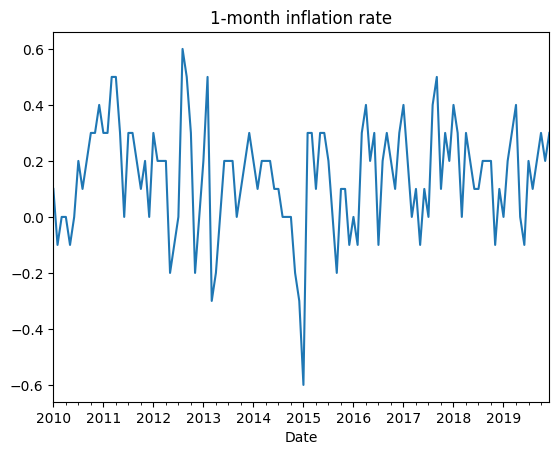

In [203]:
df['1-Month % Change'].plot()
plt.title('1-month inflation rate')

Text(0.5, 1.0, '12-month inflation rate')

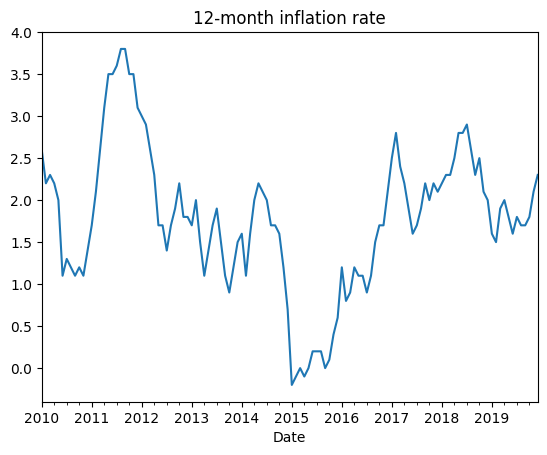

In [204]:
df['12-Month % Change'].plot()
plt.title('12-month inflation rate')

Our current main focus is the CPI index, so let's decompose this feature first.
- First, decompose the CPI column into trend, seasonal, and residual components using additive method. 
- Second, apply multiplicative method
- Since we may apply detrending method as a way to make the data stationary, we will be using backward looking moving average in order to smooth out the noise (instead of the center moving average) and reduce the number of future observation lost. 


In [205]:
df['CPI'].describe()

count    120.000000
mean     237.113133
std       11.070621
min      217.199000
25%      229.092000
50%      237.116000
75%      244.205500
max      258.616000
Name: CPI, dtype: float64

### 1.1 Additive decomposition

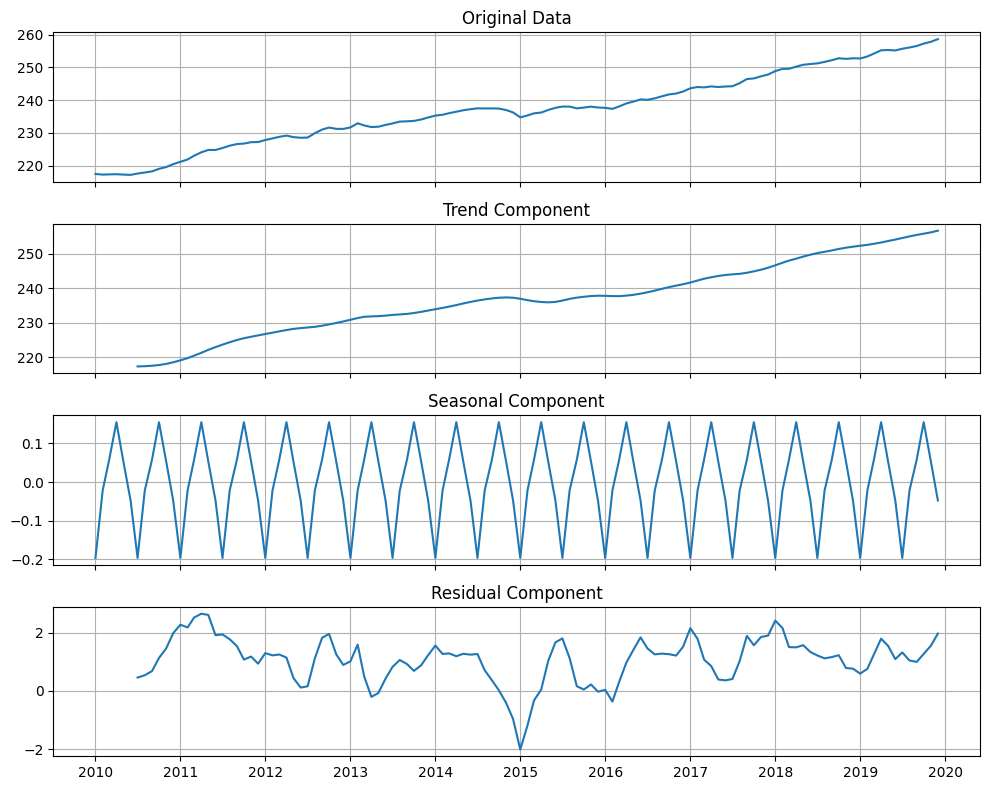

In [206]:
additive_decomposed = seasonal_decompose(df['CPI'], model='additive',two_sided= False, period= 6)

# Plot the original data, trend, seasonal, and residual components
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 8), sharex=True)

# Original data
ax1.plot(df['CPI'])
ax1.set_title('Original Data')
ax1.grid()

# Trend component
ax2.plot(additive_decomposed.trend)
ax2.set_title('Trend Component')
ax2.grid()

# Seasonal component
ax3.plot(additive_decomposed.seasonal)
ax3.set_title('Seasonal Component')
ax3.grid()

# Residual component
ax4.plot(additive_decomposed.resid)
ax4.set_title('Residual Component')
ax4.grid()

plt.tight_layout()
plt.show()


A statistical look into the seasonal component

In [207]:
additive_decomposed.seasonal.describe()

count    1.200000e+02
mean     1.665335e-16
std      1.097106e-01
min     -1.965863e-01
25%     -4.780556e-02
50%      1.572295e-02
75%      5.792690e-02
max      1.550190e-01
Name: seasonal, dtype: float64

### 1.2 Multiplicative Decomposition

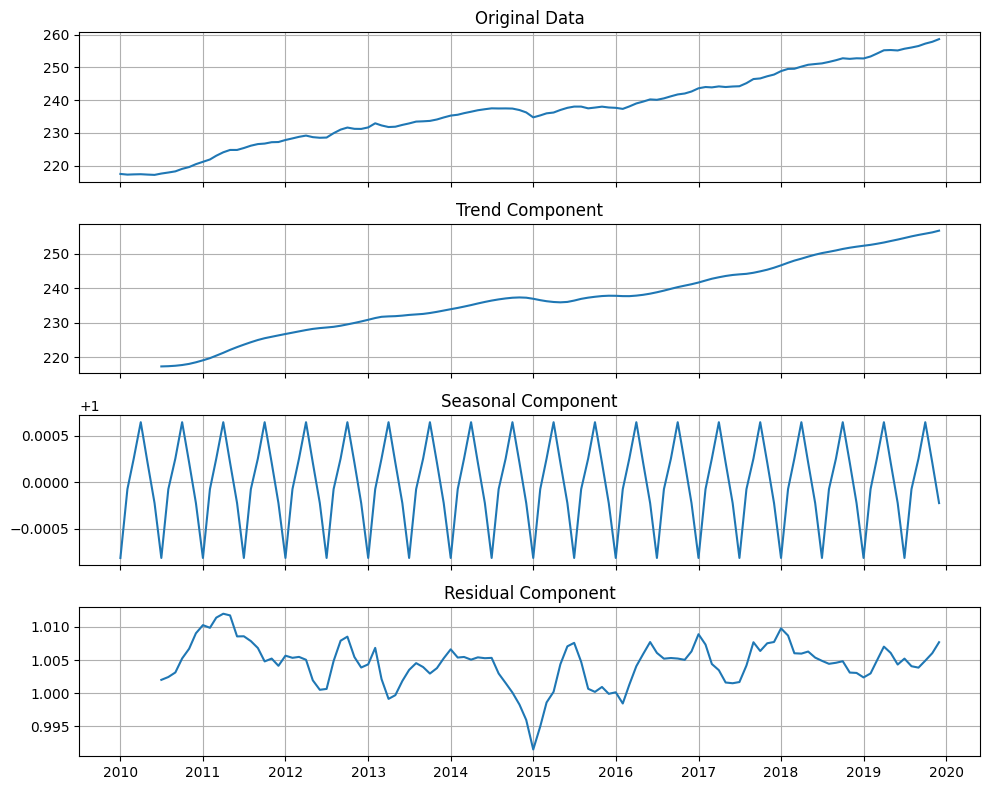

In [208]:
multiplicative_decomposed = seasonal_decompose(df['CPI'], model='multiplicative',two_sided= False, period= 6)

# Plot the original data, trend, seasonal, and residual components
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 8), sharex=True)

# Original data
ax1.plot(df['CPI'])
ax1.set_title('Original Data')
ax1.grid()

# Trend component
ax2.plot(multiplicative_decomposed.trend)
ax2.set_title('Trend Component')
ax2.grid()

# Seasonal component
ax3.plot(multiplicative_decomposed.seasonal)
ax3.set_title('Seasonal Component')
ax3.grid()

# Residual component
ax4.plot(multiplicative_decomposed.resid)
ax4.set_title('Residual Component')
ax4.grid()

plt.tight_layout()
plt.show()


### 1.3 Decomposition Conclusion

- After trying multiple periods/frequencies, we decided to use a period of 6 to decompose the CPI index as it results the perfect seasonal component. 

Both multiplicative and additive decomposition show that the trend component is the most important component in the CPI index. 

However, residuals in the multiplicative decomposition is more stable than in additive approach, so we should move forward with mulitplicative approach. 

## 2. Trend Analysis

In [209]:
# Obtain statistical attributes of the trend component
additive_decomposed.trend.describe()

count    114.000000
mean     237.094541
std       10.340160
min      217.345417
25%      230.053354
50%      236.941833
75%      244.144042
max      256.698250
Name: trend, dtype: float64

Since the series has a linear trend, it is definitely not stationary. Thus, we should attempt to make it stationary.

In addition, we can address how statistical properties of a series change over time by visualizing. This would help us check the structural break and heteroscedasticity issue. 
- The rolling window size is 12 months

In [210]:
# Create a fucntion to plot rolling variance and rolling mean
def rolling_statistics(timeseries, custom_name, window_size=12):
    # Determine rolling statistics
    rolling_mean = timeseries.rolling(window=window_size).mean()
    rolling_std = timeseries.rolling(window=window_size).std()

    # Plot rolling statistics
    plt.figure(figsize=(10, 6))
    plt.plot(rolling_mean, color='black', label='Rolling Mean')
    plt.plot(rolling_std, color='red', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation of ' + custom_name)
    plt.grid()
    plt.show()

### 2.1 Label Diffencing

First, let's work on differncing the data to see if the process can make the data more stationay. 

#### 2.1.1 First Order Differencing

In the first order differencing, we would subtract the immediate previous value from the current value to obtain the difference between two consecutive periods. 

First-Order Differencing = Value at time t - Value at time t-1

In [211]:
diff_data = df['CPI'].diff().dropna()


Text(0.5, 1.0, 'First - Order Differenced Data')

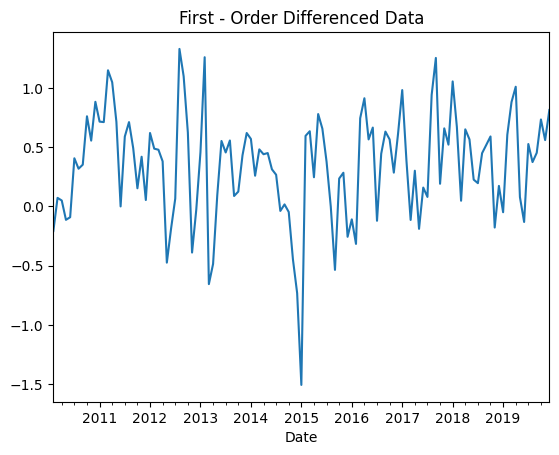

In [212]:
diff_data.plot()
plt.title('First - Order Differenced Data')

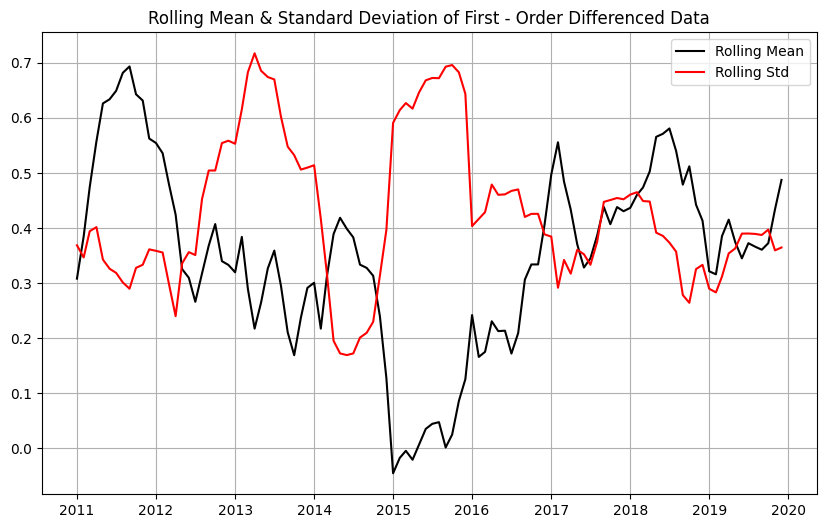

In [213]:
rolling_statistics(diff_data, 'First - Order Differenced Data')

#### 2.1.2 Second Order Differencing

In [214]:
second_order_diff = diff_data.diff().dropna()

Text(0.5, 1.0, 'Second - Order Differenced Data')

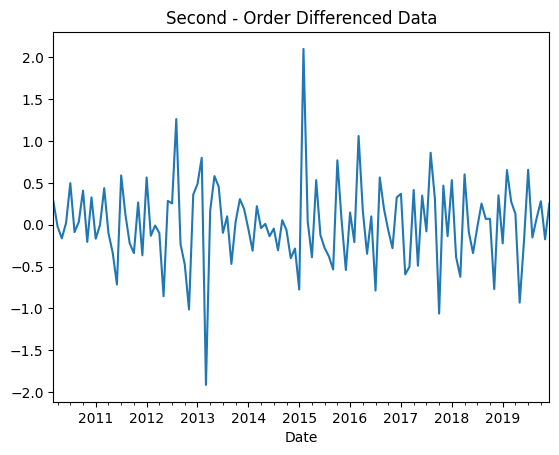

In [215]:
second_order_diff.plot()
plt.title('Second - Order Differenced Data')


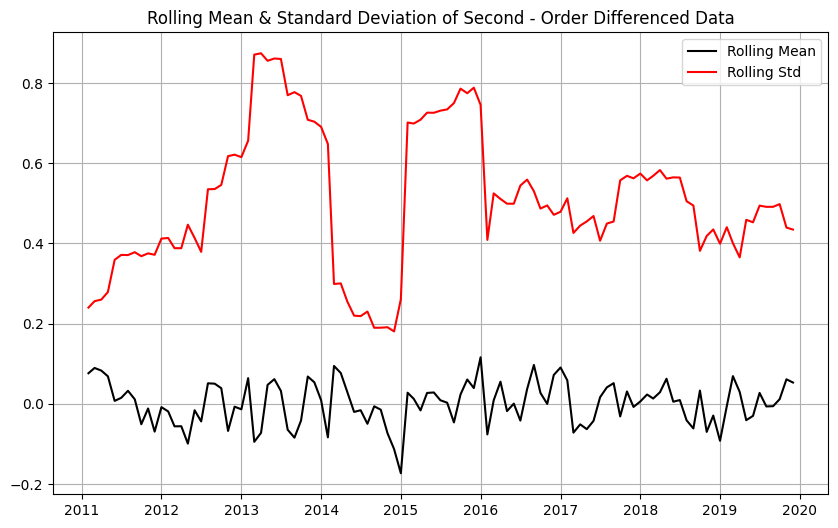

In [216]:
rolling_statistics(second_order_diff, 'Second - Order Differenced Data')

### 2.2 Label Detrending

- The method for smoothing data used in this project is backward moving average.

- Detrended data is computed by subtracting the trend values from the actual values. 

- Since we use a period of 6 to smooth out the data, the function will use a centered moving average witha window size of 6 to smooth the trend component (6 periods prior to the current value).

- As a result, we would lose 6 observations in using label detrending, compared to only 1 in first-order differencing, and 2 in second-order differencing.

In [217]:
# Here, I extract the trend component from the multiplicative decomposition. Trend values from either multiplicative or additive decompositions are identical.
trend = multiplicative_decomposed.trend

In [218]:
detrend = df['CPI']- trend

detrend.dropna(inplace=True)

Text(0.5, 1.0, 'Detrended Data')

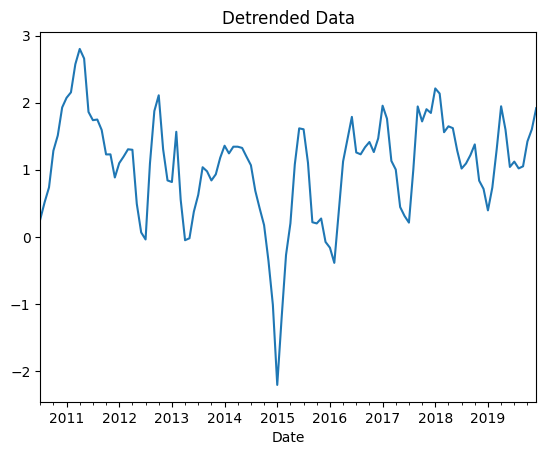

In [219]:
detrend.plot()
plt.title('Detrended Data')

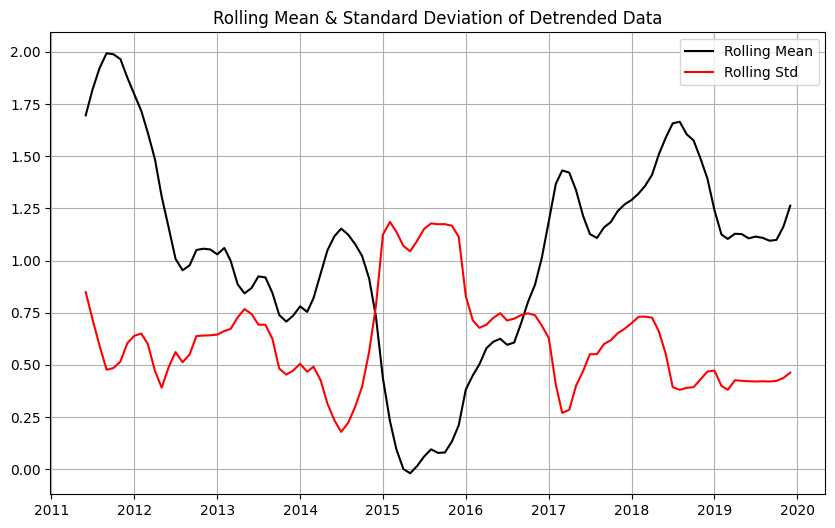

In [220]:
rolling_statistics(detrend, 'Detrended Data')

### 2.3 Differencing and Detrending Conclusion

- Mean and variance of these transformed data are not constant over time. Between the 3 transformation method, the second order differencing appear to be the most stationary. Therefore, we would move forward with second order differencing.

## 3. Label Transformation (Make it stationary)

Create a function to calculate the ADF test and print out the result. 

In [221]:
def stationary_test(input):

    result = adfuller(input)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:', result[4])

    # Reject the null hypothesis if the p-value is below the chosen significance level
    if result[1] < 0.05:
        print("The data is STATIONARY.")
    else:
        print("The data is NOT STATIONARY.")
        

In addition to the ADF test, let's use the non parametric KPSS test to confirm the stationarity of the data. If KPSS's result contradict conclusion from ADF, we need to investigate further. 

### 3.1 Augemnted Dickey-Fuller Test

To statistically verify if the data is stationary or not, we would deploy ADF test. 

- Null hypothesis: The time series contains a unit root and is non-stationary

- Alternative hypothesis is that the time series is stationary. 

To confirm that the data is stationary, we need a p-value that is lower than the significance level in order to reject the null hypothesis, and the critical values should be greater greater than the ADF statistics.

- The significance level chosen is 0.05. 

1. ADF on the orignal dataset

In [222]:
stationary_test(df['CPI'])

ADF Statistic: 0.08450407630219899
p-value: 0.9649870512135881
Critical Values: {'1%': -3.487517288664615, '5%': -2.8865777180380032, '10%': -2.5801239192052012}
The data is NOT STATIONARY.


2. ADF on the second order differenced dataset

In [223]:
stationary_test(second_order_diff)

ADF Statistic: -5.773834092562138
p-value: 5.31587155352009e-07
Critical Values: {'1%': -3.4924012594942333, '5%': -2.8886968193364835, '10%': -2.5812552709190673}
The data is STATIONARY.


### 3.2 Non-parametric KPSS test

- Null hypothesis: The time series is stationary (no unit root)

- Alternative hypothesis: The time series is stastionary (it has a unit root)

KPSS' test statistic is compared to the relevant critical values. If the test statistic is greater than the cirtical value at a chosen level of significance, we reject the null hypothesis  and conclude that the series is non-stationary with a unit root. 


In [224]:
# Create a function to perform the kpss test.
def kpss_test(input):
        result = kpss(input)
        print('KPSS Statistic:', result[0])
        print('p-value:', result[1])
        print('Critical Values:', result[3])
    
        # Reject the null hypothesis if the p-value is below the chosen significance level
        if result[1] < 0.05:
            print("The data is NOT STATIONARY.")
        else:
            print("The data is STATIONARY.")


1. KPSS test on the orignal data

In [225]:
kpss_test(df['CPI'])

KPSS Statistic: 1.7444818593540126
p-value: 0.01
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
The data is NOT STATIONARY.


C:\Users\brian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


2. KPSS test on the second-order differenced data

In [226]:
kpss_test(second_order_diff)

KPSS Statistic: 0.10677279671488885
p-value: 0.1
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
The data is STATIONARY.


C:\Users\brian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


Most critical values across level of significance are well beyond the test statistic. This supports the Null hypothesis that the series is stationary

### 3.3 ADF and KPSS test conclusion 

The second-order differencing data is found to be stationary by using ADF and KPSS test, while the original data is not stationary (as expected). Results from both test are consistent.

In [227]:
# Create a box plot to compare the distribution of the detrended data and the first-order differenced data
def cus_boxplot(data1, title1):
    fig, ax1 = plt.subplots(1, 1, figsize=(5, 5))
    sns.boxplot(data1, ax=ax1)
    ax1.set_title(title1)
    plt.show()

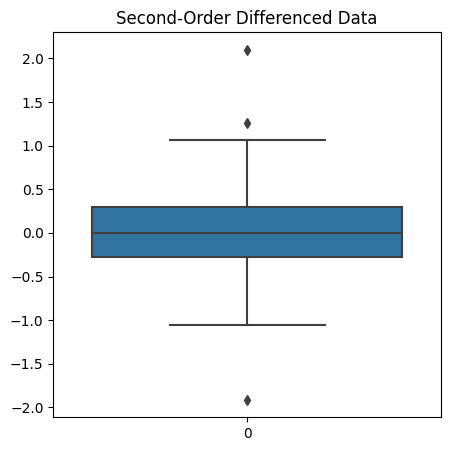

In [228]:
cus_boxplot(second_order_diff, 'Second-Order Differenced Data')

In [229]:
# Get the data statisitcal summary

print('Second order difference data statistical summary:')
second_order_diff.describe()

Second order difference data statistical summary:


count    118.000000
mean       0.008644
std        0.502357
min       -1.913000
25%       -0.279750
50%       -0.006500
75%        0.300750
max        2.100000
Name: CPI, dtype: float64

### 3.3 White Noise Check 

In this test, we would test the autocorrelation between the current value its 12 lags. If there exist a correlation between the current value and a number of its lags, then the series is not white noise

In [230]:
# Create a function to check if a pandas time series is a white noise. Import package for acirr_ljungbox test
from statsmodels.stats.diagnostic import acorr_ljungbox
def white_noise_test(input):
    # Calculate the p-value of the autocorrelation
    lags = 12
    p_val_list = []
    for i in range(1, lags):
        result = acorr_ljungbox(input, lags= lags)
        p_value = result.iloc[i-1,1]
        p_val_list.append(p_value)
    # check if all p_values in the list are below 0.05, then the time series is not a white noise
    if all(i < 0.05 for i in p_val_list):
        print('The time series is NOT a white noise.')
    

In [231]:
white_noise_test(second_order_diff)

The time series is NOT a white noise.


Since the series illustrate a correlation between the current value and its lags, the data is thus not white noise. 

## 4. Lag Analysis

To identify the useful lag variables, we can use the autocorrelation function (ACF) and Partial Autocorrelation Function (PACF) plots.

The main difference between ACF and PACF is that ACF measures the total correlation between a time series and its lagged values, while PACF measures the direct correlation between a time series and its lagged values after removing the effect of the correlations with the intervening observations. 

ACF is primarily used to determine the MA component, while the PACF plot is used to determine the AR component.

The shaded area is the signifiance level in the ACF and PACF plots. If a lag is above the shaded area, it is significantly correlated with the label. 

### 4.1 Label's ACF and PACF

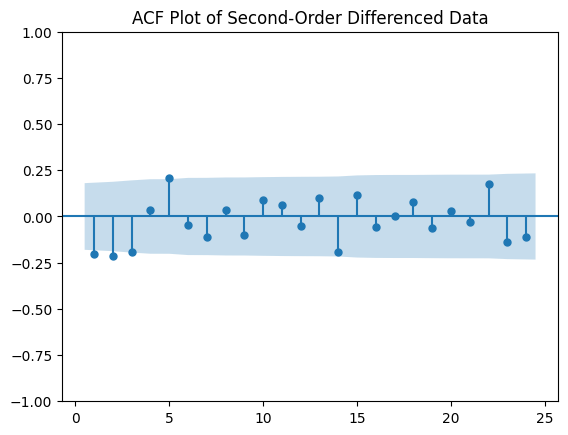

C:\Users\brian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


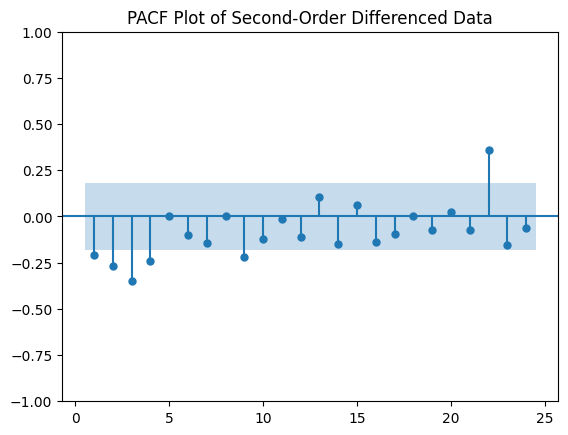

In [232]:
# ACF plot
plot_acf(second_order_diff, lags= 24, zero=False)
plt.title('ACF Plot of Second-Order Differenced Data')
plt.show()

# PACF plot
plot_pacf(second_order_diff, lags = 24, zero=False)
plt.title('PACF Plot of Second-Order Differenced Data')
plt.show()

### 4.2 Lag Analysis Conclusion 

- The ACF plot shows that the label is correlated with its lagged values up to 3 periods.

- Meanwhile, the PACF shows that the label is directly correlated with the first 4 lag values and lags of 9 and 22. We can't really be sure that lag 22 are really substantially significnnt as it shows on the graph due to the small size of the data.

## 5. Splitting the data

In [233]:
# Training, validation, and test sets

train = second_order_diff.loc['2010-01-01':'2016-12-31']

val = second_order_diff.loc['2017-01-01':'2018-12-31']

test = second_order_diff.loc['2019-01-01':'2019-12-31']


# II. Modeling 1 (Lag Predictors only)

## 1. Base model: ARIMA(1,2,1)

- The ARIMA(p,d,q) model contains 3 main components: AR, I (differencing), and MA.

- After carefully taking into consideration, second-order differencing seems to be the best way to make the data stationary so decided to use it as the base model for comparision purpose.

- The model takes into account 1 lagged values, 1 lagged errors, and 2 order differencing. 

### 1.1 Model Executing

In [234]:
# Create and fit an ARIMA(1,2,1) model to the training set

#! Here we set I = 0 since we have manually differenced the data
base_model = ARIMA(train, order=(1,0,1)).fit()


C:\Users\brian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\brian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


### 1.2 Model Summary

In [235]:
base_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    CPI   No. Observations:                   82
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 -49.853
Date:                Fri, 05 May 2023   AIC                            107.706
Time:                        14:30:09   BIC                            117.333
Sample:                    03-01-2010   HQIC                           111.571
                         - 12-01-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0016      0.006     -0.283      0.777      -0.013       0.010
ar.L1          0.4187      0.124      3.378      0.001       0.176       0.662
ma.L1         -0.9999     16.353     -0.061      0.951     -33.051      31.052
sigma2         0.1892      3.085      0.061      0.951      -5.858       6.237
===================================================================================
Ljung-Box (L1) (Q):                   0.32   Jarque-Bera (JB):                13.99
Prob(Q):                              0.57   Prob(JB):                         0.00
Heteroskedasticity (H):               2.26   Skew:                            -0.59
Prob(H) (two-sided):                  0.04   Kurtosis:                         4.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

- The lag of 1 component is found statistically insignificant since it has a very high p-value. Meanwhile, the AR component, which is the error term of the 1st lag. 

- The negative figure for skew and kurtosis also tell us about the distribution of the model's residuals as they are found to be skewed to the left and contain a fat tail. 

### 1.3 Predicting the Validation set

- if possible, please repeat the mean, standard deviation of the label here (2nd-order differenced)

In [236]:
# Forecast values for the validation set
validation_forecast = base_model.forecast(steps=len(val))

Text(0.5, 1.0, 'ARIMA(1,0,1)')

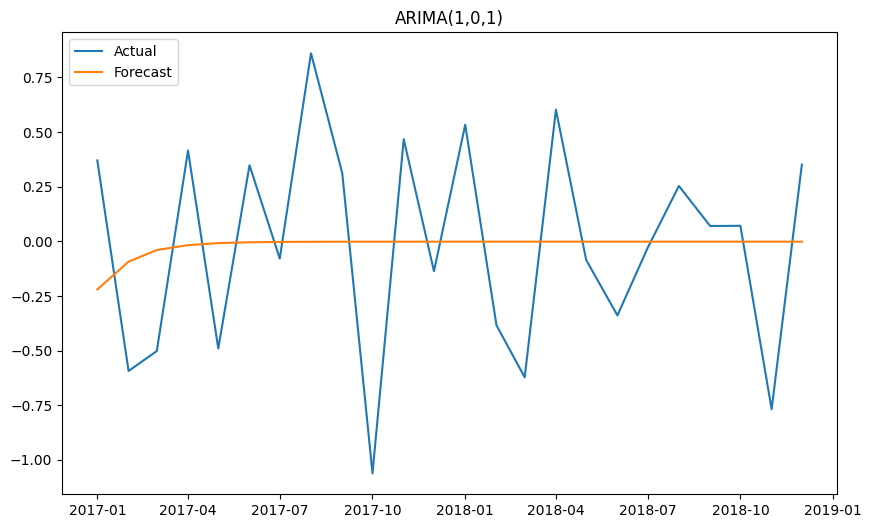

In [237]:
# Plot the forecasted values and the actual values
plt.figure(figsize=(10, 6))
plt.plot(val, label='Actual')
plt.plot(validation_forecast, label='Forecast')
plt.legend(loc='upper left')
plt.title('ARIMA(1,0,1)')


### 1.4 Model Evaluation

In [238]:
# Calculate evaluation metrics
mae = np.mean(np.abs(validation_forecast - val))
mse = np.mean((validation_forecast - val)**2)
rmse = np.sqrt(mse)

# Print evaluation metrics
print(f"MAE: {mae:.2f}, MSE: {mse:.2f}, RMSE: {rmse:.2f}")

MAE: 0.41, MSE: 0.24, RMSE: 0.49


## 2. ARIMA with more ARs and MAs

From ACF and PACF results above, we were able to identify lags that are significantly correlated with the label, 

- ACF's result is helpful in determining AR components, while PACF's helps determine MA components

From the graphs earlier, we would sequtially add MA and AR component to the model and observe how AIC and BIC change.

- A lower BIC and AIC are preferred. 

Let's write a for loop to loop through the potential models and view the results. 

C:\Users\brian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\brian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


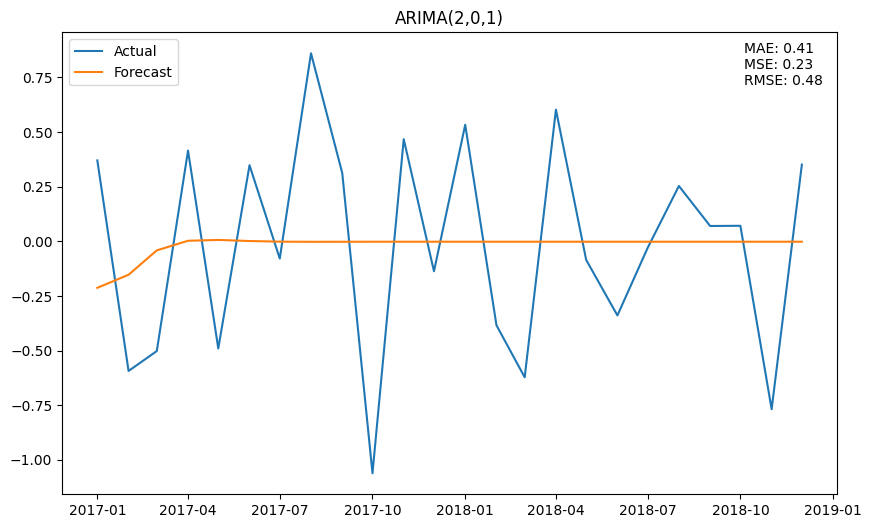

                               SARIMAX Results                                
Dep. Variable:                    CPI   No. Observations:                   82
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 -48.888
Date:                Fri, 05 May 2023   AIC                            107.775
Time:                        14:30:09   BIC                            119.809
Sample:                    03-01-2010   HQIC                           112.607
                         - 12-01-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0019      0.005     -0.366      0.714      -0.012       0.008
ar.L1          0.4770      0.139      3.422      0.001       0.204       0.750
ar.L2         -0.1539      0.148     -1.042      0.2

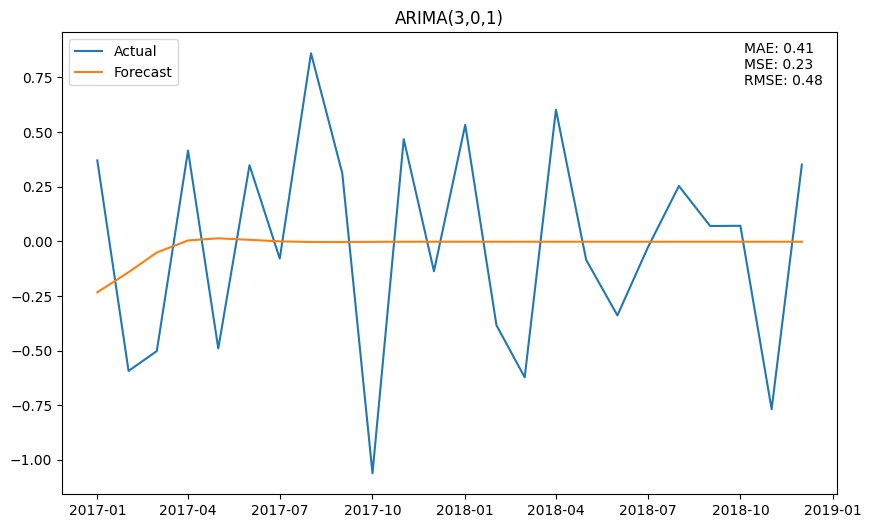

                               SARIMAX Results                                
Dep. Variable:                    CPI   No. Observations:                   82
Model:                 ARIMA(3, 0, 1)   Log Likelihood                 -48.806
Date:                Fri, 05 May 2023   AIC                            109.611
Time:                        14:30:10   BIC                            124.052
Sample:                    03-01-2010   HQIC                           115.409
                         - 12-01-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0020      0.005     -0.391      0.696      -0.012       0.008
ar.L1          0.4681      0.152      3.087      0.002       0.171       0.765
ar.L2         -0.1331      0.246     -0.540      0.5

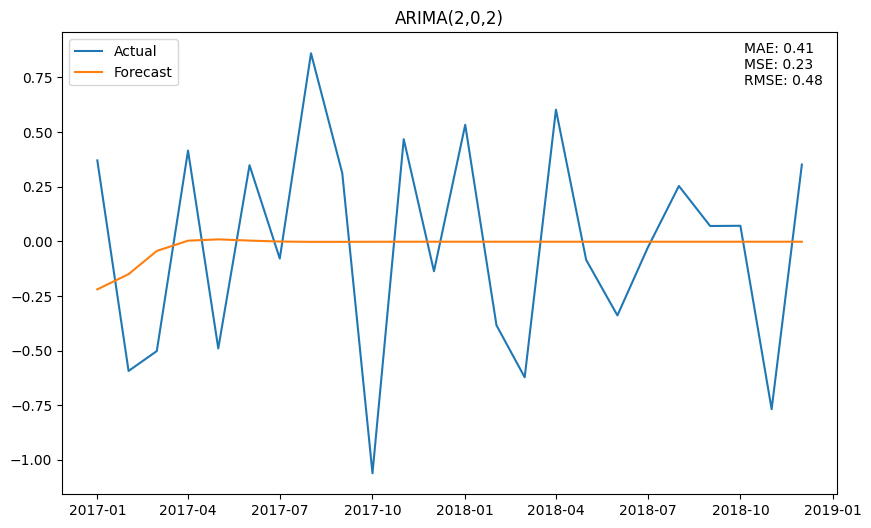

                               SARIMAX Results                                
Dep. Variable:                    CPI   No. Observations:                   82
Model:                 ARIMA(2, 0, 2)   Log Likelihood                 -48.861
Date:                Fri, 05 May 2023   AIC                            109.723
Time:                        14:30:10   BIC                            124.163
Sample:                    03-01-2010   HQIC                           115.520
                         - 12-01-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0019      0.005     -0.371      0.711      -0.012       0.008
ar.L1          0.5679      1.071      0.530      0.596      -1.532       2.668
ar.L2         -0.1934      0.360     -0.537      0.5

C:\Users\brian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


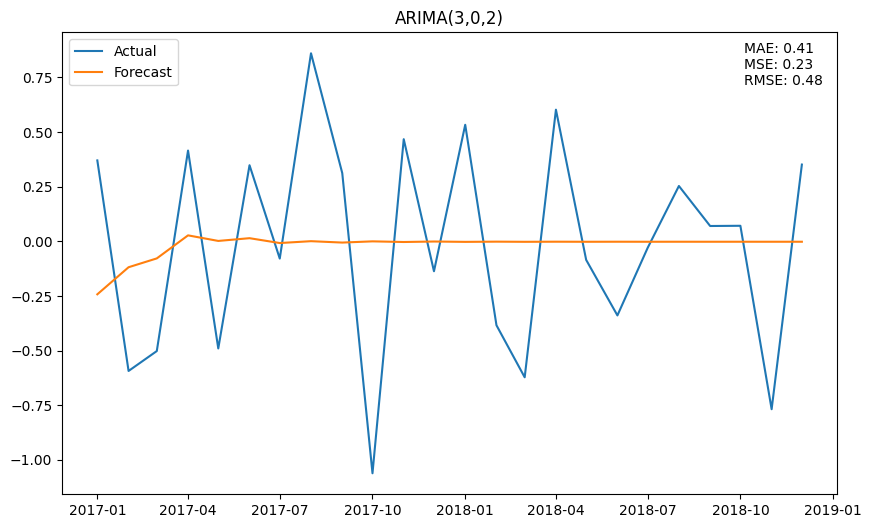

                               SARIMAX Results                                
Dep. Variable:                    CPI   No. Observations:                   82
Model:                 ARIMA(3, 0, 2)   Log Likelihood                 -48.575
Date:                Fri, 05 May 2023   AIC                            111.150
Time:                        14:30:11   BIC                            127.997
Sample:                    03-01-2010   HQIC                           117.914
                         - 12-01-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0020      0.005     -0.386      0.700      -0.012       0.008
ar.L1         -0.1126      0.913     -0.123      0.902      -1.902       1.677
ar.L2          0.1532      0.444      0.345      0.7

C:\Users\brian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


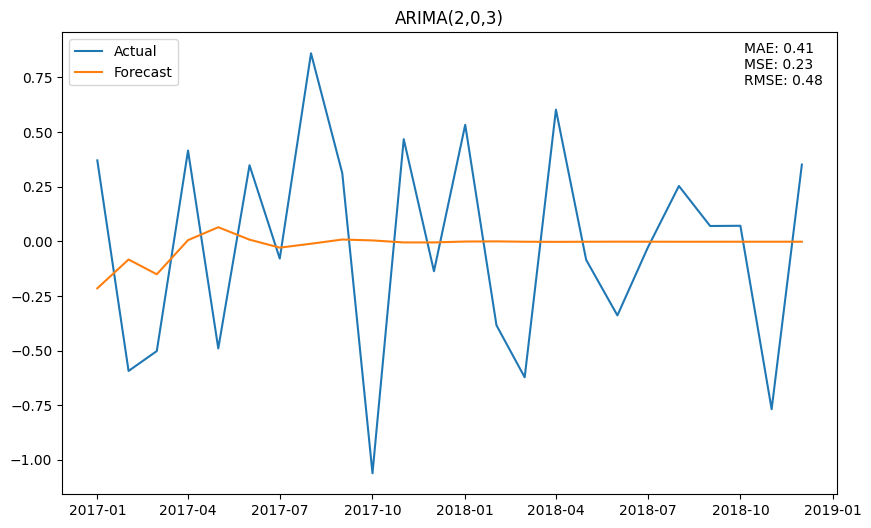

C:\Users\brian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


                               SARIMAX Results                                
Dep. Variable:                    CPI   No. Observations:                   82
Model:                 ARIMA(2, 0, 3)   Log Likelihood                 -47.710
Date:                Fri, 05 May 2023   AIC                            109.420
Time:                        14:30:11   BIC                            126.267
Sample:                    03-01-2010   HQIC                           116.183
                         - 12-01-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0019      0.005     -0.378      0.705      -0.012       0.008
ar.L1          0.1895      0.562      0.337      0.736      -0.911       1.291
ar.L2         -0.4357      0.260     -1.677      0.0

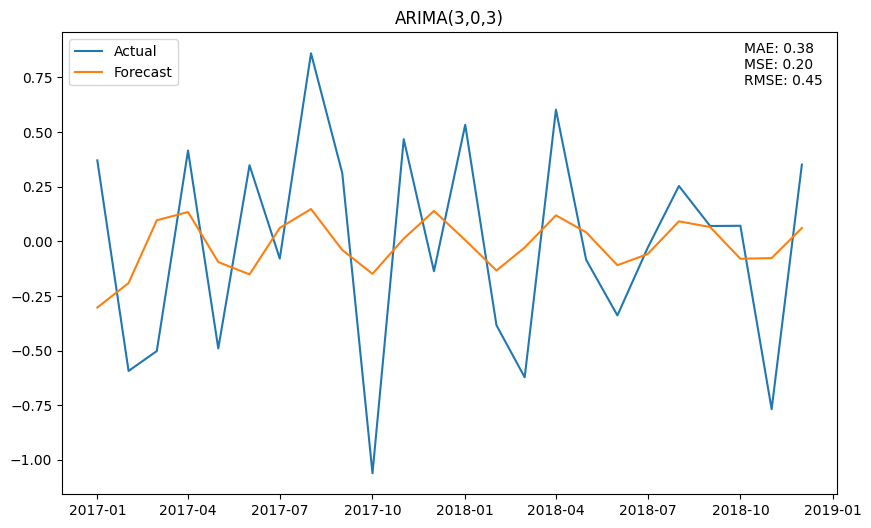

                               SARIMAX Results                                
Dep. Variable:                    CPI   No. Observations:                   82
Model:                 ARIMA(3, 0, 3)   Log Likelihood                 -46.342
Date:                Fri, 05 May 2023   AIC                            108.683
Time:                        14:30:12   BIC                            127.937
Sample:                    03-01-2010   HQIC                           116.413
                         - 12-01-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0018      0.005     -0.343      0.732      -0.012       0.009
ar.L1          0.5092      0.170      2.988      0.003       0.175       0.843
ar.L2         -0.9978      0.135     -7.388      0.0

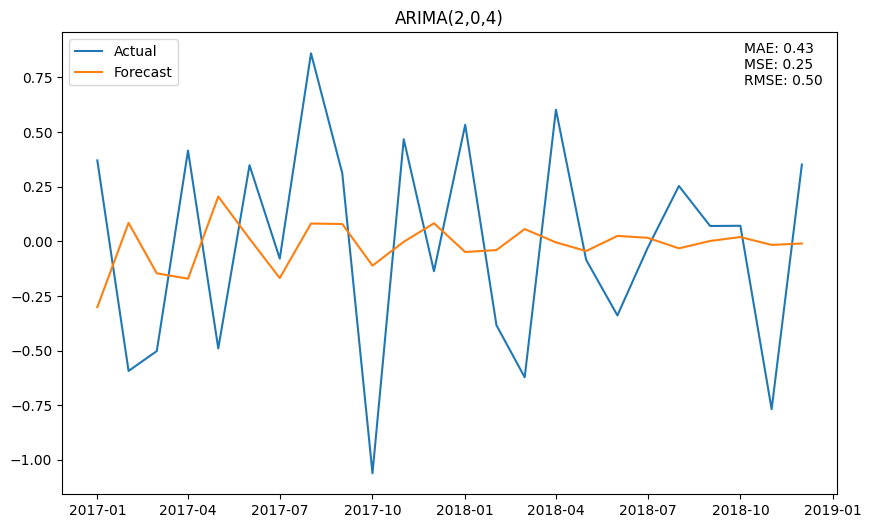

                               SARIMAX Results                                
Dep. Variable:                    CPI   No. Observations:                   82
Model:                 ARIMA(2, 0, 4)   Log Likelihood                 -46.320
Date:                Fri, 05 May 2023   AIC                            108.640
Time:                        14:30:13   BIC                            127.894
Sample:                    03-01-2010   HQIC                           116.370
                         - 12-01-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0018      0.003     -0.562      0.574      -0.008       0.005
ar.L1         -0.5633      0.207     -2.721      0.007      -0.969      -0.158
ar.L2         -0.7682      0.185     -4.156      0.0

C:\Users\brian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\brian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\brian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


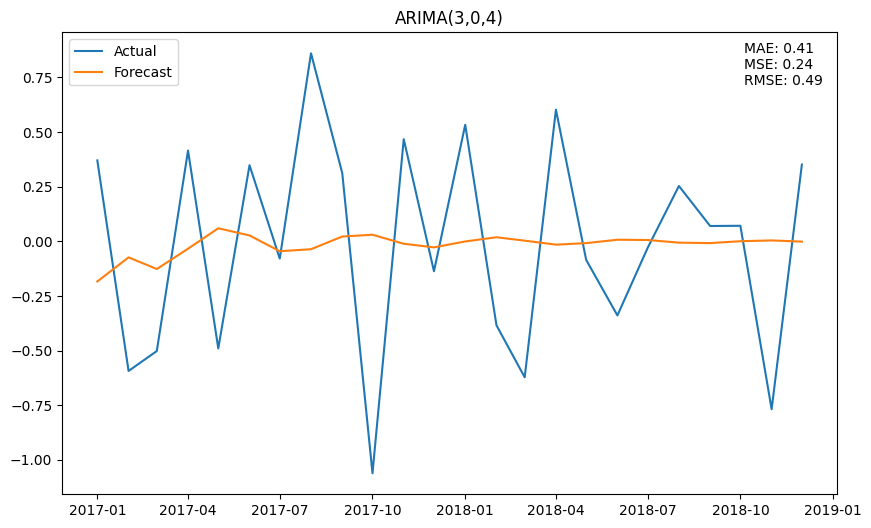

                               SARIMAX Results                                
Dep. Variable:                    CPI   No. Observations:                   82
Model:                 ARIMA(3, 0, 4)   Log Likelihood                 -47.271
Date:                Fri, 05 May 2023   AIC                            112.542
Time:                        14:30:13   BIC                            134.202
Sample:                    03-01-2010   HQIC                           121.238
                         - 12-01-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0015      0.006     -0.259      0.796      -0.012       0.010
ar.L1          0.7087      0.955      0.742      0.458      -1.164       2.581
ar.L2         -0.8670      0.334     -2.595      0.0

In [239]:
ar = [2,3]
ma = [1,2,3,4]

for i in ma:

    for j in ar:
        
        # train and fit the model
        
        model = ARIMA(train, order=(j,0,i)).fit(method_kwargs={'maxiter': 100})
        
        validation_forecast = model.forecast(steps=len(val))
        
        # Calculate evaluation metrics
        
        mae = np.mean(np.abs(validation_forecast - val))
        
        mse = np.mean((validation_forecast - val)**2)
        
        rmse = np.sqrt(mse)
        
        # Plot the forecasted values and the actual values
        
        plt.figure(figsize=(10, 6))
        
        plt.plot(val, label='Actual')
        
        plt.plot(validation_forecast, label='Forecast')
        
        plt.legend(loc='upper left')
        
        plt.title(f'ARIMA({j},0,{i})')
        
        plt.text(0.88, 0.98, f'MAE: {mae:.2f}\nMSE: {mse:.2f}\nRMSE: {rmse:.2f}', 
                 transform=plt.gca().transAxes, verticalalignment='top')
        
        plt.show()

        # Attacht the model's summary right below the graph

        print(model.summary())
      

## 2. ARIMA Model's Conclusion

- The best ARIMA model so far is ARIMA(3,0,3). For some other ARIMA model versions, the maximum likelihood optimization method fails to converge. Therefore, it leads to poor predictions, as we can see there is a horizontal line for some ARIMA model's predictions, which is completely different than the ARIMA(3,0,3)

# III. Engineearing Models With Ext Components 

## 1. Preprocessing Predictors 

### 1.1 Import and format data

First, we need to import data with external predictors 

In [240]:
predictors = pd.read_csv('full_data.csv', index_col='Date', parse_dates=True)

In [241]:
# Get some basic infor from the data 
predictors.describe().round(2)

,Money_Stock,T_Bill_DA,Interbank_DA,PCE,UnRate,PPI,PPM,T10Y3M,CrudeOil,Deposits,IndPro,RealBrdExRate,ConsumSent,FedSurDef,USDtoEuro,WageSal
count,158.00,159.00,159.00,159.00,159.00,159.00,159.00,159.00,159.00,159.00,159.00,159.00,159.00,159.00,159.00,159.00
mean,13726.67,0.06,0.07,13102.31,6.05,205.18,0.25,1.57,71.34,5.84,99.09,92.50,82.21,-102417.67,1.20,8382.64
std,4042.07,0.09,0.09,2139.65,2.26,22.00,0.28,1.01,22.52,8.69,3.80,8.65,12.83,147643.03,0.11,1490.00
min,8458.10,0.00,0.00,10056.10,3.40,181.00,0.00,-1.20,16.55,-21.80,84.60,78.43,50.00,-864074.07,0.99,6211.20
25%,10594.97,0.00,0.01,11288.60,4.00,192.75,0.08,0.99,51.48,2.60,97.49,83.22,73.05,-173136.28,1.11,7100.95
50%,12930.25,0.01,0.02,12720.60,5.40,200.70,0.14,1.61,71.38,4.90,99.77,95.04,82.50,-97597.00,1.18,8105.90
75%,15216.85,0.09,0.11,14364.70,7.85,204.30,0.29,2.22,92.48,7.90,102.15,98.71,93.80,-30054.54,1.31,9334.60
max,21703.20,0.39,0.40,18104.20,14.70,280.25,0.97,3.68,114.84,73.10,104.12,112.98,101.40,308215.06,1.45,11765.60


In [242]:
# Make the date consistent with the CPI data
predictors = predictors.loc[:'2019-12-31']

### 1.2 Apply first order differencing on predictors

- Since we have taken differencing on CPI, it makes sense to take transform predictors to at least a first order differencing as well. Also, we would like to see how the change in these variables affect movement in the label.
- Also, as I have attempted to use the original data, the multicollinarity issue was so serious that we can't move forward with it.



In [243]:
# apply diff on all columns in predictors 
predictors = predictors.diff().dropna()

### 1.3 Normalize Predictors 

#### 1.3.1 Remove Outliers

All predictors are deemed to be equally important but they appear to be on different scale, thus 

In [244]:
# Visualize the data by plotting their distributions and boxplots
# sns.pairplot(predictors)

In [245]:
# Replace all outliers in the predictors file using IQR method
def replace_outliers(data):
    for col in data.columns:
        q1 = data[col].quantile(0.25)
        q3 = data[col].quantile(0.75)
        iqr = q3 - q1
        
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        
        data[col] = np.where(data[col] < lower_bound, lower_bound, data[col])
        data[col] = np.where(data[col] > upper_bound, upper_bound, data[col])
    return data


In [246]:
clean_predictors = replace_outliers(predictors)

#### 1.3.2 Normalize predictors

In [247]:
# Normalize clean predictors data using min-max scaler, and convert it to a dataframe
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
clean_predictors = scaler.fit_transform(clean_predictors)
clean_predictors = pd.DataFrame(clean_predictors, columns=predictors.columns, index=predictors.index)

### 1.4 Merge with the label

In [248]:
# Merge the clean predictors data with the CPI data
full_data = pd.merge(second_order_diff, clean_predictors, left_index=True, right_index=True)


## 2. Correlation Analysis

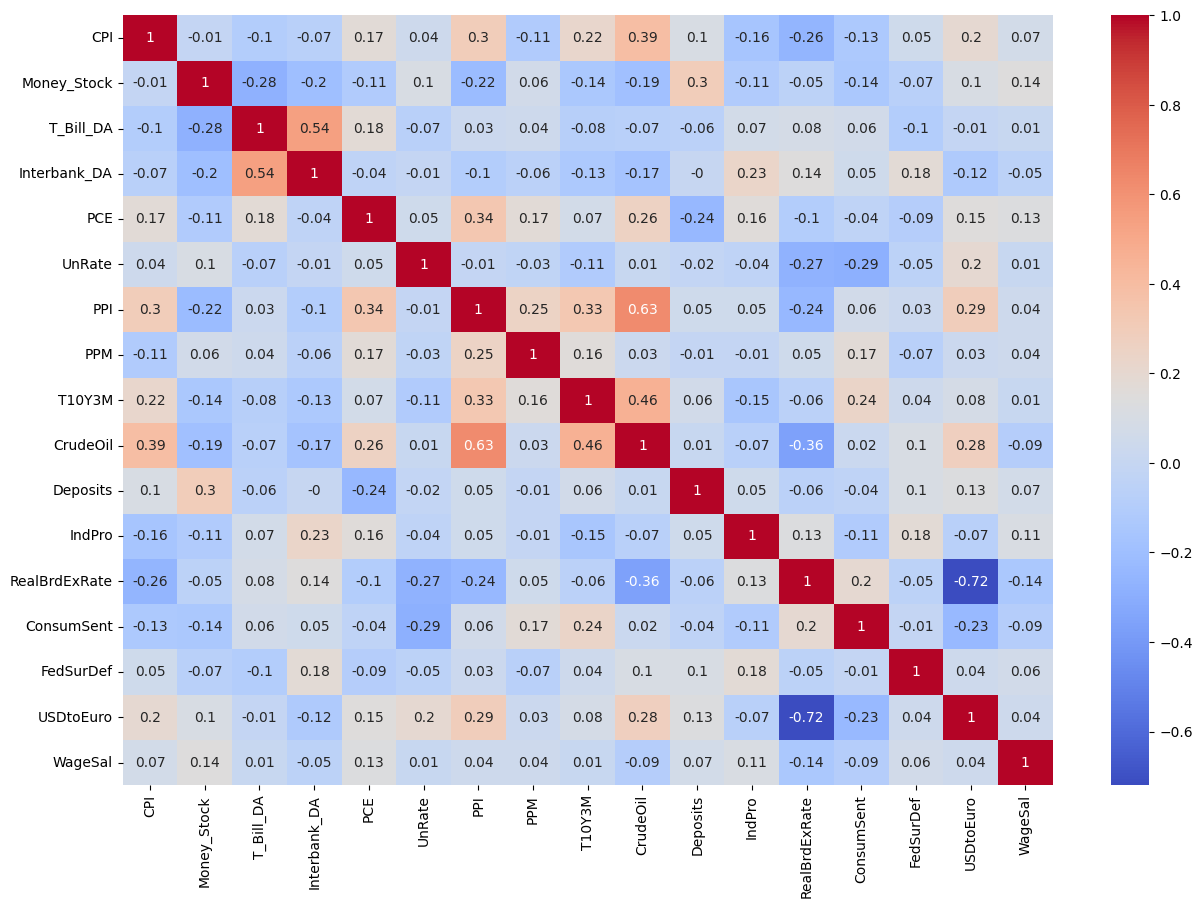

In [249]:
# Calculate the correlation matrix of full_data and visualize it using heatmap
corr_matrix = full_data.corr().round(2)
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

### 2.1 Correlation Analysis Conclusion

- Most features are moderately or weakly correlated with CPI. In economic sense, they should have a strong correlation with the label, however, since we have differenced both label and features, the strong correlation no longer holds. 

- Though some features like Money_Stock (M2 money supply) and FedSurDef are found to have a small correlation with the label, it might still be useful based on our domain knowledge. 
 
- In addition, since correlation measures only linear relationships, non-linear relationships between predictors and lable can still be significant and useful for prediction and they won't be captured by correlation coefficients. 


## 3. Feature Selection with Lasso Regression

- Though the current set of variables look good. Next, we apply Lasso Regression to filter the number of predictors even further in order to retain the most important variables only. 

In [250]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LassoCV
# split the data 
target = 'CPI'

train = full_data.loc['2010-01-01':'2016-12-31']

val = full_data.loc['2017-01-01':'2018-12-31']

test = full_data.loc['2019-01-01':'2019-12-31']

x_train = train.drop(columns = [target])

y_train = train[target]

x_val = val.drop(columns = [target])

y_val = val[target]

The best alpha as performed below is the one that provides the optimal balance between fitting the data and preventing overfitting. 

In [251]:
# Create and fit a lasso regression with cross validation to find the best alpha
model = LassoCV(alphas = None, cv = 3, random_state=123).fit(x_train, y_train)

best_alpha = model.alpha_

print(f"Best alpha: {best_alpha:.4f}")

Best alpha: 0.0243


- Though we have found the best alpha, we are unable to apply it to the lasso regresion since it would only keep Crude oil as the sole predictor for the model. 

- Therfore, we reduce alpha to 0.01, while maintaining the same RMSE but it include more predictors for the model.

In [252]:
# Now we can fit the model with the best alpha
final_lasso = Lasso(alpha=0.01, random_state=123).fit(x_train, y_train)

In [253]:
# Evaluate the model performance on the validation set 
val_predictions = final_lasso.predict(x_val)
val_mse = mean_squared_error(y_val, val_predictions)
val_rmse = np.sqrt(val_mse)
print(f'Validation RMSE: {val_rmse:.2f}\n')

Validation RMSE: 0.46



In [254]:
# Insepct the coefficients to see which predictors were retained in the model 
coef_df = pd.DataFrame({'Feature': x_train.columns, 'Coefficient': final_lasso.coef_})
coef_df = coef_df.sort_values(by='Coefficient', ascending=False)
# print Feature from coef_df where Coefficient is different from 0

print('Here is the list of predictors that were retained in the lasso regression using alpha = 0.01')

coef_df[coef_df['Coefficient'] != 0]

Here is the list of predictors that were retained in the lasso regression using alpha = 0.01


,Feature,Coefficient
8,CrudeOil,0.605490
7,T10Y3M,0.164022
3,PCE,0.118148
9,Deposits,0.100243
10,IndPro,-0.045501
13,FedSurDef,-0.063552
12,ConsumSent,-0.183486


In [255]:
# extract a vector names for these retained variables. 
selected_predictors = coef_df[coef_df['Coefficient'] != 0]['Feature'].values

## 4. Random Forest

In [256]:
# Import necessary libraries for random forest regression 
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

### 4.1 Random Forest with No Lags

#### 4.1.1 Default Setting's Hyperparameters

Create a base random forest regression model

In [257]:
rf_base = RandomForestRegressor(random_state=123)

# Train the base model 

rf_base.fit(x_train, y_train)

RandomForestRegressor(random_state=123)

Predict and Evaluate the model's metrics

In [258]:
# Predict the validation target variable
base_rf_pred = rf_base.predict(x_val)

# Evaluation 

mse = mean_squared_error(y_val, val_predictions)

rmse = np.sqrt(mse)

mae = np.mean(np.abs(val_predictions - y_val))


Visualizing Actual and Predicted Values of random forest model with default setting

In [259]:
def plot_default_setting_predictions(actual, predicted, title):
    """
    Plots the actual and predicted values of a time series.
    
    Args:
        actual (series): The actual values of the time series
        predicted (series): The predicted values of the time series
        title (string): The title of the plot
    """
    # Adding the index of the actual series to the predicted series 
    predicted = pd.Series(predicted, index=actual.index)
    
    plt.figure(figsize=(10, 6))
    plt.plot(actual, label='Actual')
    plt.plot(predicted, label='Predicted')
    plt.legend(loc='upper left')
    plt.text(0.88, 0.98, f'MAE: {mae:.2f}\nMSE: {mse:.2f}\nRMSE: {rmse:.2f}', 
                 transform=plt.gca().transAxes, verticalalignment='top')
    plt.title(title)
    # Create a small subtitle with a different color font
    plt.text(0.34, 1.1, "Default Setting's Hyperparameters", color='red', transform=plt.gca().transAxes, verticalalignment='top')
    plt.show()

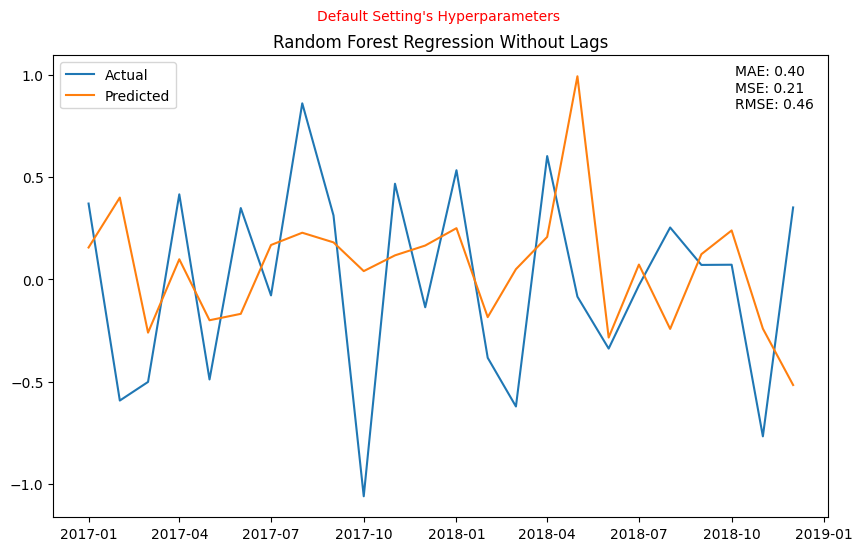

In [260]:
plot_default_setting_predictions(y_val, base_rf_pred, 'Random Forest Regression Without Lags')

#### 4.1.2 Hyperparameter Tuning

- There are two common fine-tunning method for random forest: Grid Search and Random Search.

Define hyperparameter search space for both grid search random search

In [261]:
# Hyperparameter search space
param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [10, 20, 30, 50, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False],
}

Chooose a search method (GridSearchCV or RandomizedSearchCV) and fit the model:

In [262]:
# Grid search

grid_search = GridSearchCV(estimator=rf_base, 
    param_grid=param_grid, 
    cv=3, 
    n_jobs=-1, 
    verbose=2)

# Random search

# n_iter: Number of random parameter combinations to try

random_search = RandomizedSearchCV(estimator=rf_base, 
    param_distributions=param_grid, 
    n_iter=100, 
    cv=5, 
    n_jobs=-1, 
    verbose=2, 
    random_state=123)

# Fit the search object, here we can use either random search or grid searchq

grid_search.fit(x_train, y_train)

random_search.fit(x_train, y_train)

Fitting 3 folds for each of 1080 candidates, totalling 3240 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=123),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 50, None],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 500]},
                   random_state=123, verbose=2)

Get the best hyperparameters from the both hyperparameter search methods

In [263]:
grid_search_params = grid_search.best_params_

random_search_params = random_search.best_params_


# Create a data frame that combines both grid_search_params and random_search_params
grid_search_params_df = pd.DataFrame(grid_search_params, index=[0])

random_search_params_df = pd.DataFrame(random_search_params, index=[0])

combined_params_df = pd.concat([grid_search_params_df, random_search_params_df], axis=0)

combined_params_df.index = ['Grid Search', 'Random Search']

combined_params_df


,bootstrap,max_depth,max_features,min_samples_leaf,min_samples_split,n_estimators
Grid Search,True,10,sqrt,4,10,200
Random Search,True,10,log2,4,5,500


Train the random forest model with the best hyperparameters. After multiple attempts, the RMSE of both grid search and random search is identical.

Therefore, for simplicity purpose, we would move forward with the model with hyperparameters from grid search.

In [264]:
# Instantiate the model with the best hyperparameters
tunned_rf_regressor = RandomForestRegressor(**grid_search_params, random_state=123)

# Train the model 
tunned_rf_regressor.fit(x_train, y_train)

RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_leaf=4,
                      min_samples_split=10, n_estimators=200, random_state=123)

Make predicitons and evaluate the model performance using RMSE

In [265]:
# Make predictions
y_pred = tunned_rf_regressor.predict(x_val)

# Evaluate the model 

mse = mean_squared_error(y_val, y_pred)

rmse = np.sqrt(mse)

mae = np.mean(np.abs(y_pred - y_val))

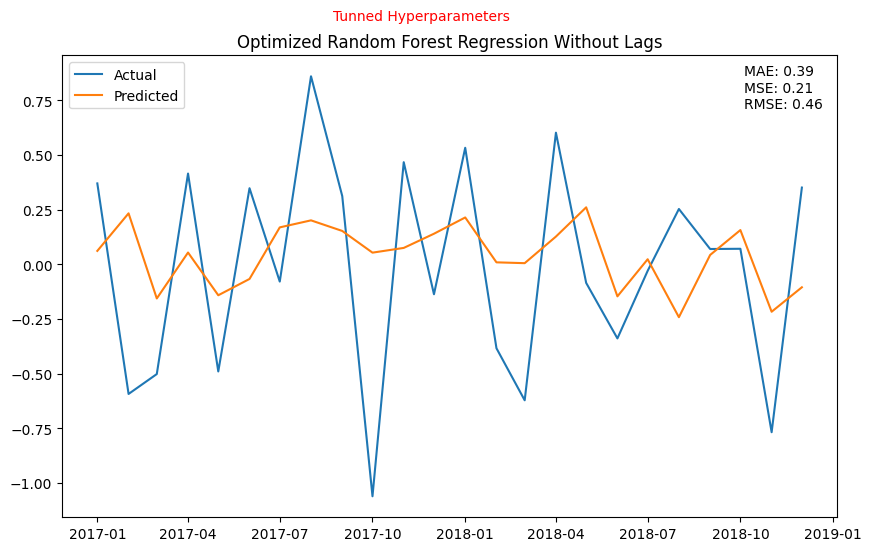

In [266]:
# Plot y_val and y_pred on the same graph, but first, we need to add a time index to y_pred
y_pred = pd.Series(y_pred, index=y_val.index)

plt.figure(figsize=(10, 6))

plt.plot(y_val, label='Actual')

plt.plot(y_pred, label='Predicted')

plt.legend(loc='upper left')

plt.text(0.88, 0.98, f'MAE: {mae:.2f}\nMSE: {mse:.2f}\nRMSE: {rmse:.2f}', 
                 transform=plt.gca().transAxes, verticalalignment='top')

plt.text(0.35, 1.1, 'Tunned Hyperparameters', 
         color='red', 
         transform=plt.gca().transAxes, 
         verticalalignment='top')

plt.title('Random Forest Regression Without Lags')

plt.show()

### 4.2 Random Forest with Lags

From the best ARIMA model, which is ARIMA(3,0,3), we can see that the first 3 lags appear to be statistically significant to predict the CPI, therefore, we decide include them to the model.

In [267]:
# Create a function create lag features for a time series
def create_lag_features(df, target, lags):
    """
    Creates lag features for a time series.
    
    Args:
        df (dataframe): A dataframe containing the time series data
        target (string): The column name of the target variable
        lags (list): A list of lag values to create features for
        
    Returns:
        The original dataframe with added columns containing lag features
    """
    df = df.copy()
    
    for lag in lags:
        df['lag_' + str(lag)] = df[target].shift(lag)
        
    return df

In [268]:
# Adding 3 lags to the full_data dataset
full_data = create_lag_features(full_data, target, [1, 2, 3])

full_data.dropna(inplace=True)

In [269]:
# Create training, validation, and test sets again 
train_w_lags = full_data.loc['2010-01-01':'2016-12-31']

val_w_lags = full_data.loc['2017-01-01':'2018-12-31']

test_w_lags = full_data.loc['2019-01-01':'2019-12-31']

x_train_w_lags = train_w_lags.drop(columns = [target])

y_train_w_lags = train_w_lags[target]

x_val_w_lags = val_w_lags.drop(columns = [target])

y_val_w_lags = val_w_lags[target]

Create the base Random Forest

In [270]:
rf_w_lags = RandomForestRegressor(random_state=123)

# Train the base model 
rf_w_lags.fit(x_train_w_lags, y_train_w_lags)

RandomForestRegressor(random_state=123)

#### 4.2.1 Default's Setting Hyperparameters

In [271]:
# Make predictions
y_pred = rf_w_lags.predict(x_val_w_lags)

# Evaluate the model 

mse = mean_squared_error(y_val_w_lags, y_pred)

rmse = np.sqrt(mse)

mae = np.mean(np.abs(y_pred - y_val_w_lags))

Visualize the actual values and prediction of the model with default setting

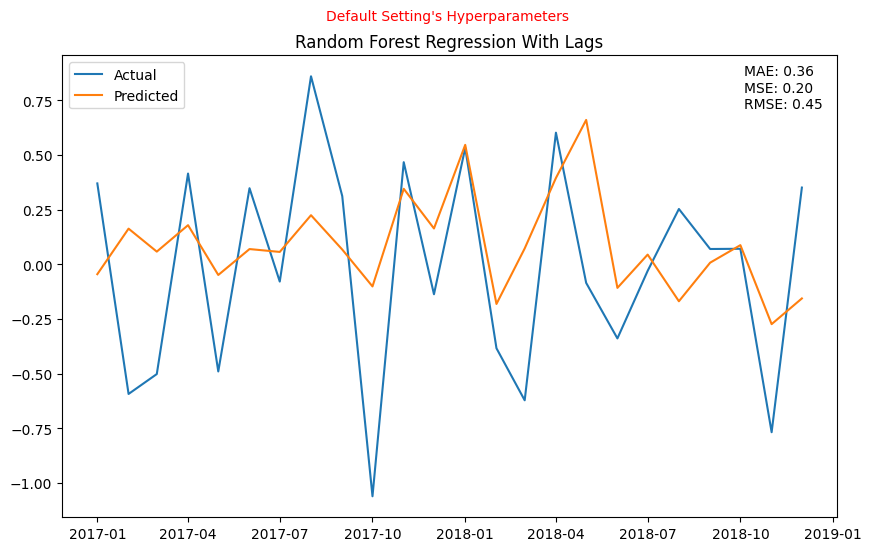

In [272]:
plot_default_setting_predictions(y_val_w_lags, y_pred, 'Random Forest Regression With Lags')

#### 4.2.2 Hyperparameter Tuning

Define hyperparameter search space for grid search or random search:

In [273]:
# Grid search

grid_search = GridSearchCV(estimator=rf_w_lags, 
    param_grid=param_grid, 
    cv=3, 
    n_jobs=-1, 
    verbose=2)

# Random search

# n_iter: Number of random parameter combinations to try

random_search = RandomizedSearchCV(estimator=rf_w_lags, 
    param_distributions=param_grid, 
    n_iter=100, 
    cv=5, 
    n_jobs=-1, 
    verbose=2, 
    random_state=123)

# Fit the search object, here we can use either random search or grid searchq

grid_search.fit(x_train_w_lags, y_train_w_lags)

random_search.fit(x_train_w_lags, y_train_w_lags)

Fitting 3 folds for each of 1080 candidates, totalling 3240 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=123),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 50, None],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 500]},
                   random_state=123, verbose=2)

Obtain the optimal hyperparameters both grid search and random search applied on the data with lags. 

In [274]:
grid_search_params = grid_search.best_params_

random_search_params = random_search.best_params_

# Create a data frame that combines both grid_search_params and random_search_params
grid_search_params_df = pd.DataFrame(grid_search_params, index=[0])

random_search_params_df = pd.DataFrame(random_search_params, index=[0])

combined_params_df = pd.concat([grid_search_params_df, random_search_params_df], axis=0)

combined_params_df.index = ['Grid Search', 'Random Search']

combined_params_df

,bootstrap,max_depth,max_features,min_samples_leaf,min_samples_split,n_estimators
Grid Search,False,10,sqrt,2,5,500
Random Search,True,20,log2,1,10,300


**Grid Search**

In [275]:
# Instantiate the model with grid search hyperparameters
grid_search_rf_regressor = RandomForestRegressor(**grid_search_params, random_state=123)

# Train the model 
grid_search_rf_regressor.fit(x_train_w_lags, y_train_w_lags)

RandomForestRegressor(bootstrap=False, max_depth=10, max_features='sqrt',
                      min_samples_leaf=2, min_samples_split=5, n_estimators=500,
                      random_state=123)

Prediction and Evaluation

In [276]:
# Make predictions
grid_search_y_pred = grid_search_rf_regressor.predict(x_val_w_lags)

# Evaluate the model 

mse = mean_squared_error(y_val_w_lags, grid_search_y_pred)

rmse = np.sqrt(mse)

mae = np.mean(np.abs(grid_search_y_pred - y_val_w_lags))

Visualizing Actual and Predicted Values of Grid Search Hyperparameters

In [277]:
# Create a function to visualize actual and predicted values
def plot_grid_search_predictions(actual, predicted, title):
    """
    Plots the actual and predicted values of a time series.
    
    Args:
        actual (series): The actual values of the time series
        predicted (series): The predicted values of the time series
        title (string): The title of the plot
    """
    # Adding the index of the actual series to the predicted series 
    predicted = pd.Series(predicted, index=actual.index)
    
    plt.figure(figsize=(10, 6))
    plt.plot(actual, label='Actual')
    plt.plot(predicted, label='Predicted')
    plt.legend(loc='upper left')
    plt.text(0.88, 0.98, f'MAE: {mae:.2f}\nMSE: {mse:.2f}\nRMSE: {rmse:.2f}', 
                 transform=plt.gca().transAxes, verticalalignment='top')
    plt.title(title)
    # Create a small subtitle with a different color font
    plt.text(0.41, 1.1, 'Grid Search', color='red', transform=plt.gca().transAxes, verticalalignment='top')
    plt.show()
    

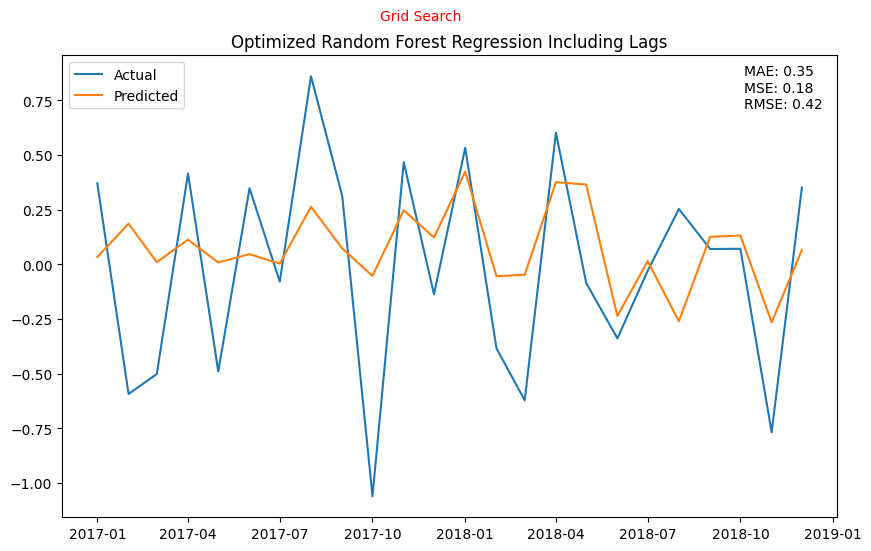

In [278]:
plot_grid_search_predictions(y_val_w_lags, grid_search_y_pred, 'Optimized Random Forest Regression Including Lags')


**Random Search**

In [279]:
# Instantiate the model with random search hyperparameters 
random_search_rf_regressor = RandomForestRegressor(**random_search_params, random_state = 123)

# Fit the model 

random_search_rf_regressor.fit(x_train_w_lags, y_train_w_lags)

RandomForestRegressor(max_depth=20, max_features='log2', min_samples_split=10,
                      n_estimators=300, random_state=123)

Prediction and Evaluation

In [280]:
# Make Predictions 
random_search_y_pred = random_search_rf_regressor.predict(x_val_w_lags)

# Evaluate the model 

mse = mean_squared_error(y_val_w_lags, random_search_y_pred)

rmse  = np.sqrt(mse)

mae = np.mean(np.abs(random_search_y_pred - y_val_w_lags))

Visualizing Actual and Predicted values of Random Search Hyperparameters

In [281]:
# Create a function to visualize actual and predicted values
def plot_random_search_predictions(actual, predicted, title):
    """
    Plots the actual and predicted values of a time series.
    
    Args:
        actual (series): The actual values of the time series
        predicted (series): The predicted values of the time series
        title (string): The title of the plot
    """
    # Adding the index of the actual series to the predicted series 
    predicted = pd.Series(predicted, index=actual.index)
    
    plt.figure(figsize=(10, 6))
    plt.plot(actual, label='Actual')
    plt.plot(predicted, label='Predicted')
    plt.legend(loc='upper left')
    plt.text(0.88, 0.98, f'MAE: {mae:.2f}\nMSE: {mse:.2f}\nRMSE: {rmse:.2f}', 
                 transform=plt.gca().transAxes, verticalalignment='top')
    plt.title(title)
    # Create a small subtitle with a different color font
    plt.text(0.41, 1.1, 'Random Search', color='red', transform=plt.gca().transAxes, verticalalignment='top')
    plt.show()
    

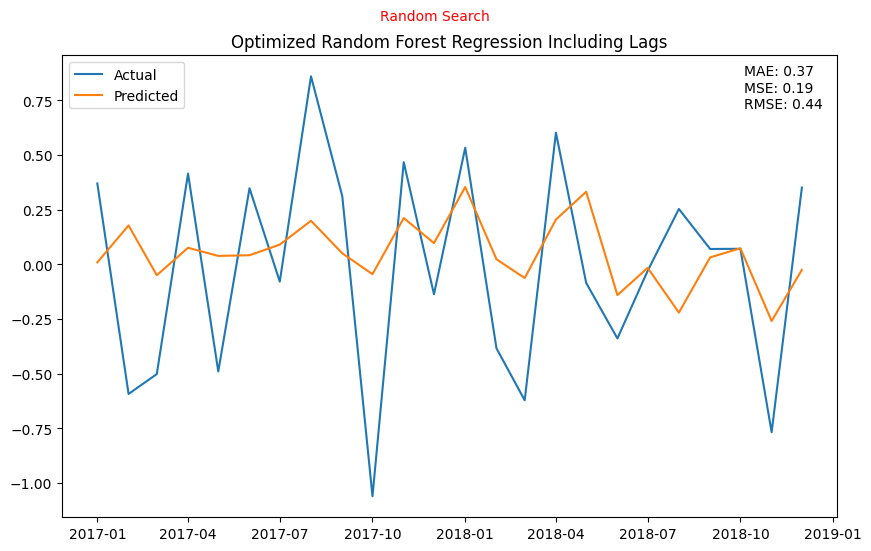

In [282]:
plot_random_search_predictions(y_val_w_lags, random_search_y_pred, 'Optimized Random Forest Regression Including Lags')

### 4.2 Random Forest Conclusion

- Regarding the model's performance, the model with lags performs better than the model without lags.

- The model with lags also has a lower RMSE than the model without lags.

- The model with lags also has a lower RMSE than the best ARIMA model, which is ARIMA(3,0,3).

- Regarding model without lags, tunning the hyperparameters DOES NOT improve the model's performance. It is indicated by the fact that the RMSE of the model with default setting and the model with tunning hyperparameters are identical, though MAE of the tunned Forest is slightly lower than the default Forest (0.39 vs 0.40).

- Regarding model with lags, tunning the hyperparameters DOES improve the model's performance. It is indicated by the fact that the RMSE of tunning hyperparameters of both grid search and random search are both moderately lower than in default settting model. 

- The model yield the greatest performance is the model with lags and hyperparameters from grid search, with the RMSE of 0.42. 
 